# Analysis of the historical price of a troy ounce of silver adjusted for inflation

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from statsmodels.tsa.seasonal import STL

In [2]:
# Get silver price and US CPI dfs
df_ag = pd.read_csv("../data/AG.csv")
df_cpi = pd.read_csv("../data/US_CPI_M.csv")

In [3]:
# Append the CPI estimate for April of 2024 to the CPI df
new_row = pd.DataFrame({"year_month": ["2024-04"], "rate": [3.4]})
df_cpi = pd.concat([df_cpi, new_row], ignore_index=True)

In [4]:
# Set date as index for both dfs
for df in df_ag, df_cpi:
    date_col = df.columns[0]
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)

In [5]:
# Set charts theme
sns.set_theme(style="darkgrid", rc={"grid.alpha": 0.33})
plt.style.use("dark_background")

### Adjustment of silver price for inflation (using 2023 prices)

In [6]:
# Make CPI rates decimal
df_cpi["rate"] = df_cpi["rate"] / 100

In [7]:
# Get cumulative product of rates until 2023 (which is the base year)
all_months = []
for month in range(1, 12 + 1):
    # Cumulative product of year over year CPI rate for each month number
    cumulative_product = np.cumprod((1 + df_cpi[:f"2023-{month:02}"]["rate"])[::-12])
    # Shift the cumulative product to align with the prior year
    cumulative_product = cumulative_product.shift(1).fillna(1)
    all_months.append(cumulative_product)

In [8]:
# Add cumulative CPI rates to the df
df_cpi["cumulative_rate"] = pd.concat(all_months)

In [9]:
# Get 2024 months cumulative rate by just inverting respective rate
df_cpi.loc[df_cpi.index.year == 2024, "cumulative_rate"] = 1 / (1 + df_cpi["rate"])

In [10]:
# Add the cumulative CPI rates to the silver price df (May values will have the same rate as April)
df_cpi_reindexed = df_cpi.reindex(df_ag.index, method="ffill")
df_ag["cpi_cumulative_rate"] = df_cpi_reindexed["cumulative_rate"]

In [11]:
# Adjust all prices to 2023 dollars
df_ag["real_price"] = df_ag["price"] * df_ag["cpi_cumulative_rate"]

## The price of silver adjusted for inflation across time

In [12]:
# Get 1-year moving average
df_ag["real_price_1y_ma"] = df_ag["real_price"].rolling(window=252).mean()

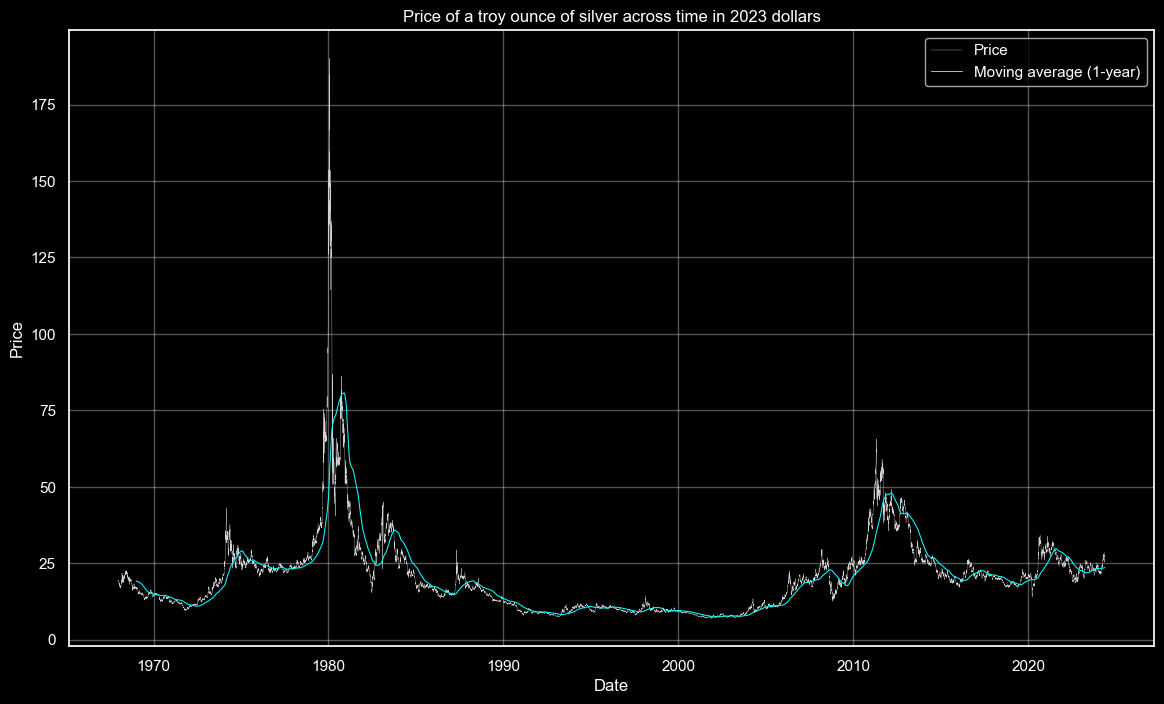

In [17]:
plt.figure(figsize=(14, 8))

sns.lineplot(data=df_ag, x=df_ag.index, y="real_price", label="Price", color="lightgrey", linewidth=0.25)
sns.lineplot(data=df_ag, x=df_ag.index, y="real_price_1y_ma", label="Moving average (1-year)", color="aqua", linewidth=0.75)

#plt.yscale("log")

plt.title("Price of a troy ounce of silver across time in 2023 dollars")
plt.xlabel("Date")
plt.ylabel("Price")

plt.show()

### Comparison of real price with nominal price

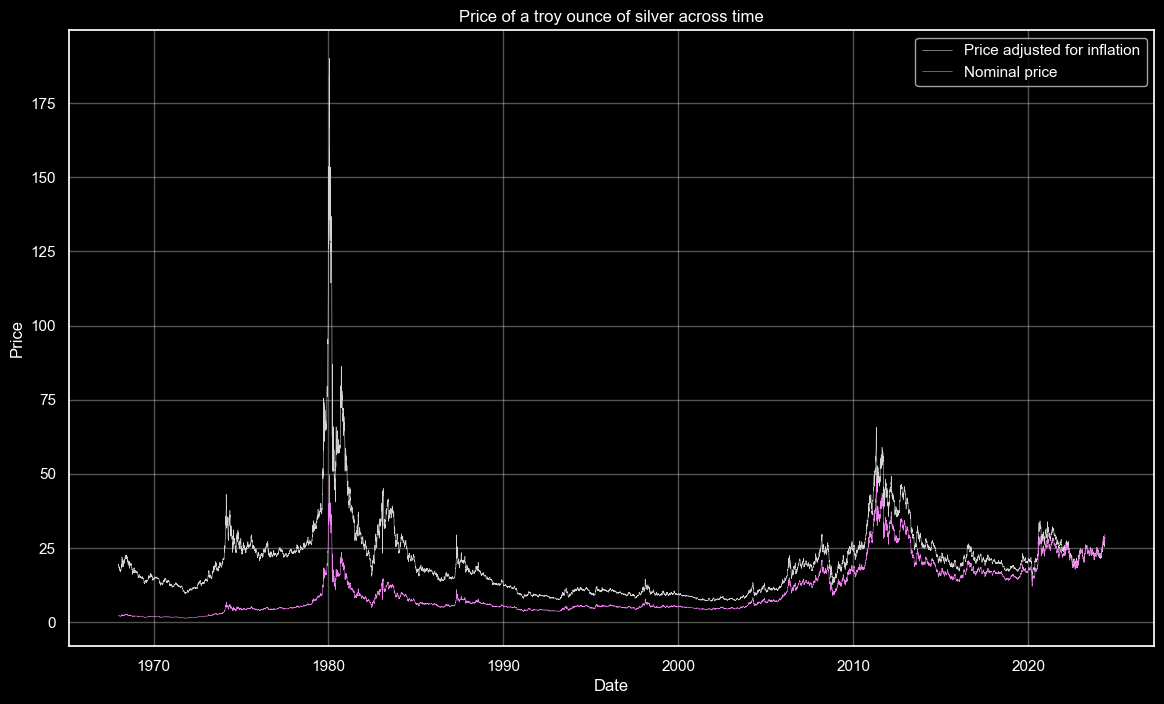

In [18]:
plt.figure(figsize=(14, 8))

sns.lineplot(data=df_ag, x=df_ag.index, y="real_price", label="Price adjusted for inflation", color="lightgrey", linewidth=0.4)
sns.lineplot(data=df_ag, x=df_ag.index, y="price", label="Nominal price", color="violet", linewidth=0.4)

#plt.yscale("log")

plt.title("Price of a troy ounce of silver across time")
plt.xlabel("Date")
plt.ylabel("Price")

plt.show()

In [19]:
# All time high
ath_date = df_ag["real_price"].idxmax()
df_ag.loc[[ath_date], ["real_price"]]

,real_price
date,
1980-01-18,190.153683


In [20]:
# All time low
atl_date = df_ag["real_price"].idxmin()
df_ag.loc[[atl_date], ["real_price"]]

,real_price
date,
2001-11-21,7.035864


In [21]:
# Peaks
peaks, _ = signal.find_peaks(df_ag["real_price"], distance=800)
df_ag.iloc[peaks].nlargest(10, "real_price").sort_values("date")[["real_price"]].transpose()

date,1968-06-12,1974-02-26,1980-01-18,1983-05-31,1987-04-27,2008-02-27,2011-04-28,2014-07-10,2020-09-01,2024-04-12
real_price,22.650167,43.092781,190.153683,41.526212,29.407638,27.470144,65.688679,27.585966,34.157389,28.0706


In [22]:
# Valleys
valleys, _ = signal.find_peaks(-df_ag["real_price"], distance=1000)
df_ag.iloc[valleys].nsmallest(10, "real_price").sort_values("date")[["real_price"]].transpose()

date,1971-11-02,1976-01-21,1982-06-07,1986-05-20,1993-03-09,1997-07-17,2001-11-21,2005-11-07,2016-01-28,2020-03-19
real_price,9.549361,20.608293,18.621085,13.553061,7.482842,8.045101,7.035864,11.630955,17.148393,14.038476


In [23]:
# Real price appreciation since first entry
first_entry_price = df_ag.iloc[0]["real_price"]
last_entry_price = df_ag.iloc[-1]["real_price"]
(last_entry_price - first_entry_price) / first_entry_price

0.5056359265824882

- ...

### Real price change year over year

In [24]:
# Get year over year real returns
# Get yearly silver real price df with first and last prices
df_ag_yearly = df_ag.groupby(df_ag.index.year)["real_price"].agg(
    first_price="first",
    last_price="last"
)
# Get year over year return
df_ag_yearly["real_price_change"] = (df_ag_yearly["last_price"] - df_ag_yearly["first_price"]) / df_ag_yearly["first_price"]

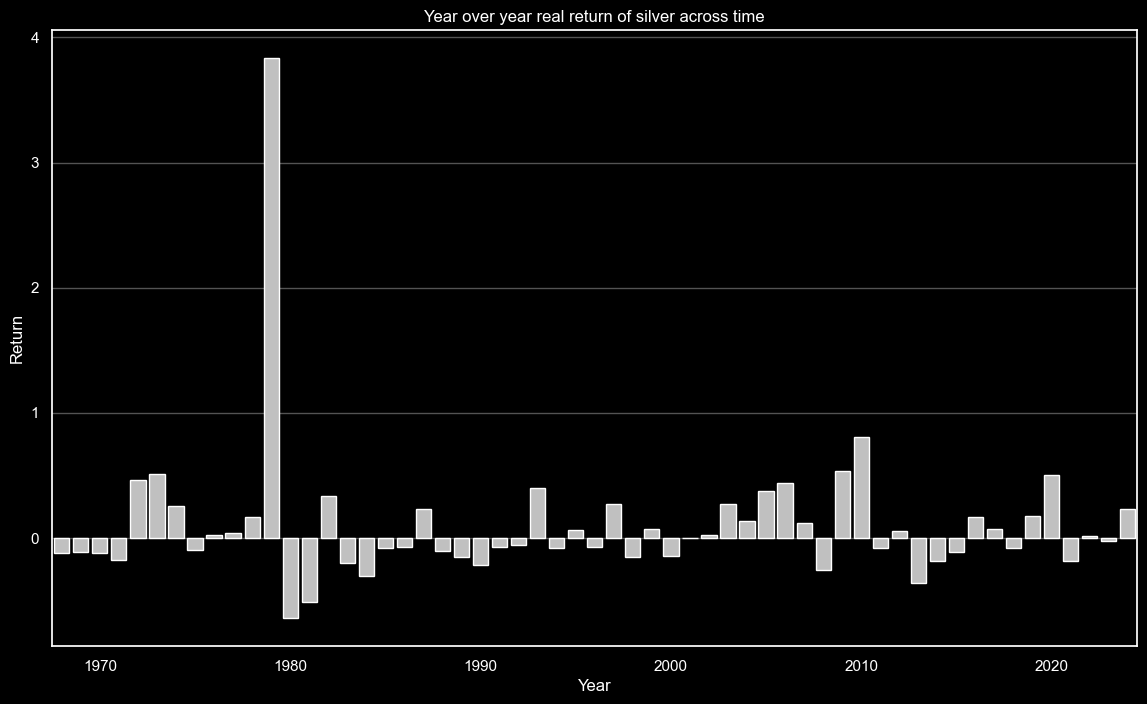

In [26]:
plt.figure(figsize=(14, 8))

sns.barplot(data=df_ag_yearly, x=df_ag_yearly.index, y="real_price_change", color="silver")

plt.title("Year over year real return of silver across time")
plt.xlabel("Year")
plt.ylabel("Return")

# Show only beginning of decade
ax = plt.gca()
for index, label in enumerate(ax.get_xticklabels()):
    if index % 10 - 2 != 0:
        label.set_visible(False)

plt.show()

In [ ]:
# Average year over year real return
df_ag_yearly["real_price_change"].mean().round(4)

In [ ]:
# Average year over year real return since 1980
df_ag_yearly.loc["1980":]["real_price_change"].mean().round(4)

In [ ]:
# Average year over year real return since 2000
df_ag_yearly.loc["2000":]["real_price_change"].mean().round(4)

In [27]:
# Average year over year real return per decade
df_ag_dec = df_ag_yearly.groupby((df_ag_yearly.index // 10) * 10)
df_ag_dec = df_ag_dec["real_price_change"].mean().round(4).reset_index()
df_ag_dec.columns = ["decade", "average_yoy_real_price_change"]
df_ag_dec.set_index("decade").transpose()

decade,1960,1970,1980,1990,2000,2010,2020
average_yoy_real_price_change,-0.116,0.4911,-0.1501,0.0166,0.15,0.0456,0.109


**Real price change**
- as espected the bar chart of the real price return is very similar, only the rates really change.

### STL decomposition (trend, seasonality, and residuals)

In [29]:
stl = STL(df_ag["real_price"], period=252).fit()

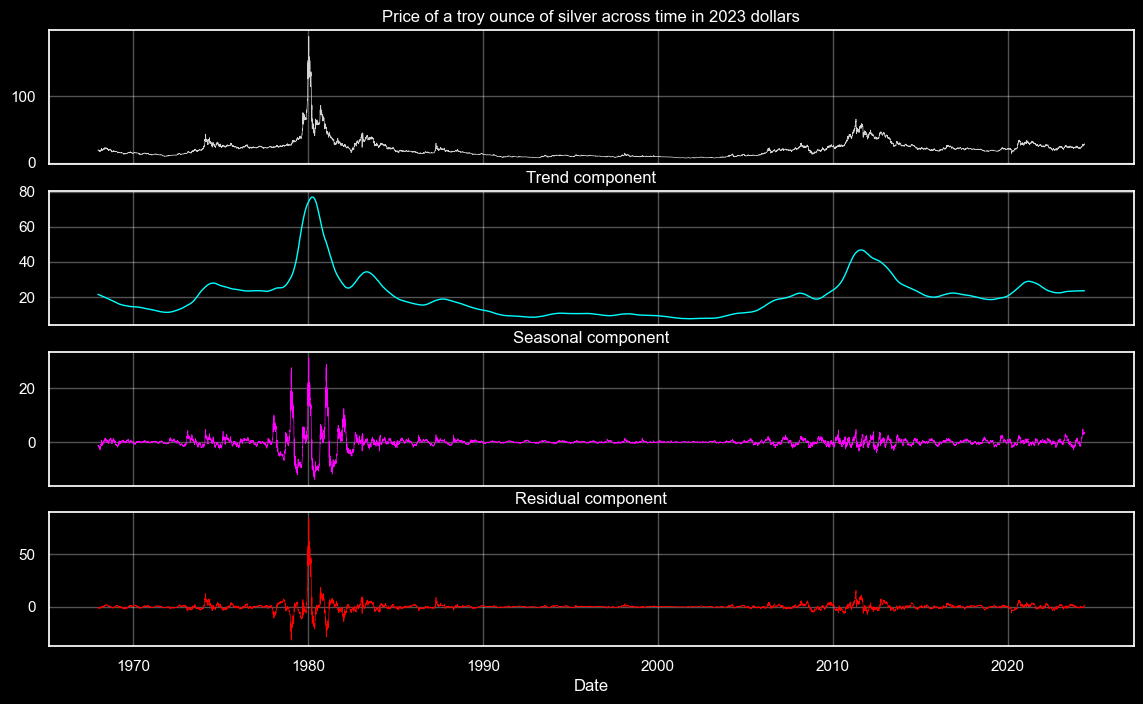

In [30]:
fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True)

axes[0].plot(df_ag.index, df_ag["real_price"], label="Original", color="lightgrey", linewidth=0.5)
axes[0].set_title("Price of a troy ounce of silver across time in 2023 dollars")

axes[1].plot(df_ag.index, stl.trend, label="Trend", color="aqua", linewidth=1)
axes[1].set_title("Trend component")

axes[2].plot(df_ag.index, stl.seasonal, label="Seasonal", color="fuchsia", linewidth=0.5)
axes[2].set_title("Seasonal component")

axes[3].plot(df_ag.index, stl.resid, label="Residual", color="red", linewidth=0.5)
axes[3].set_title("Residual component")

plt.xlabel("Date")

# plt.tight_layout()
plt.show()

#### Trend analysis

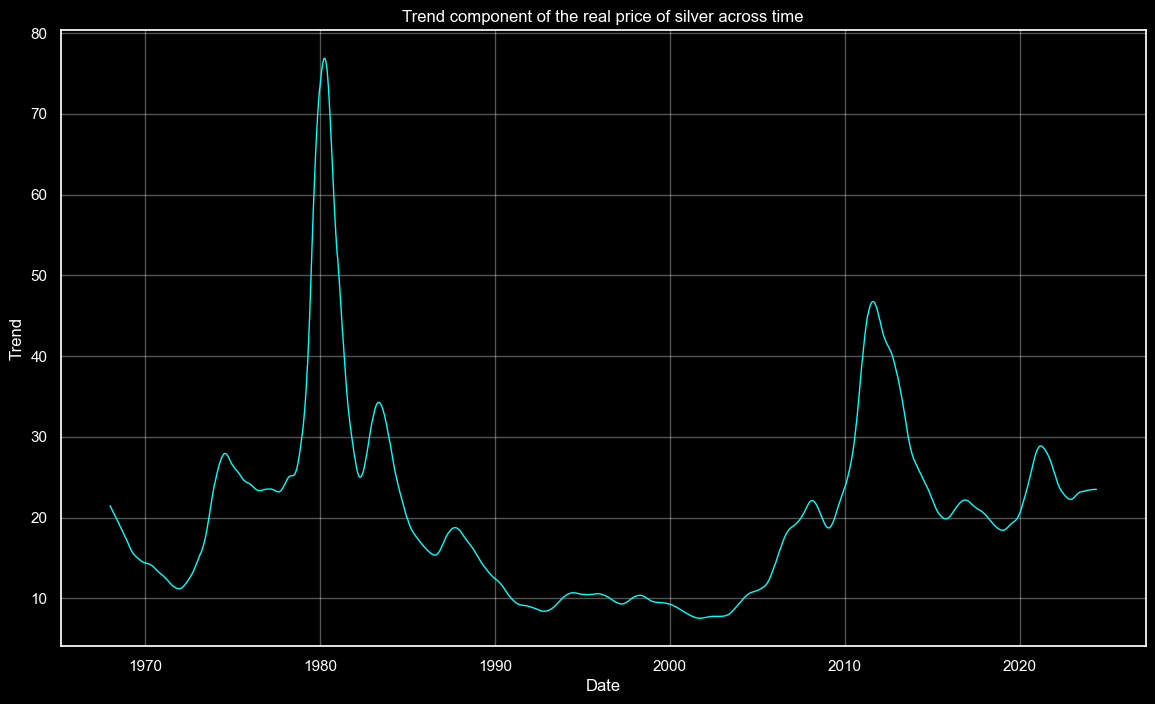

In [31]:
plt.figure(figsize=(14, 8))

plt.plot(stl.trend, color="aqua", linewidth=1)

plt.title("Trend component of the real price of silver across time")
plt.xlabel("Date")
plt.ylabel("Trend")

plt.show()

In [34]:
# Top 5 peaks
peaks, _ = signal.find_peaks(stl.trend, distance=500)
stl.trend.iloc[peaks].nlargest(5)

date
1980-04-03    76.875258
2011-08-09    46.747850
1983-05-12    34.261604
2021-03-11    28.870834
1974-07-30    27.928545
Name: trend, dtype: float64

- just like gold, valley is more clear, judging by trend, although the second peak is much smaller than the first, unlike gold.

#### Seasonality analysis

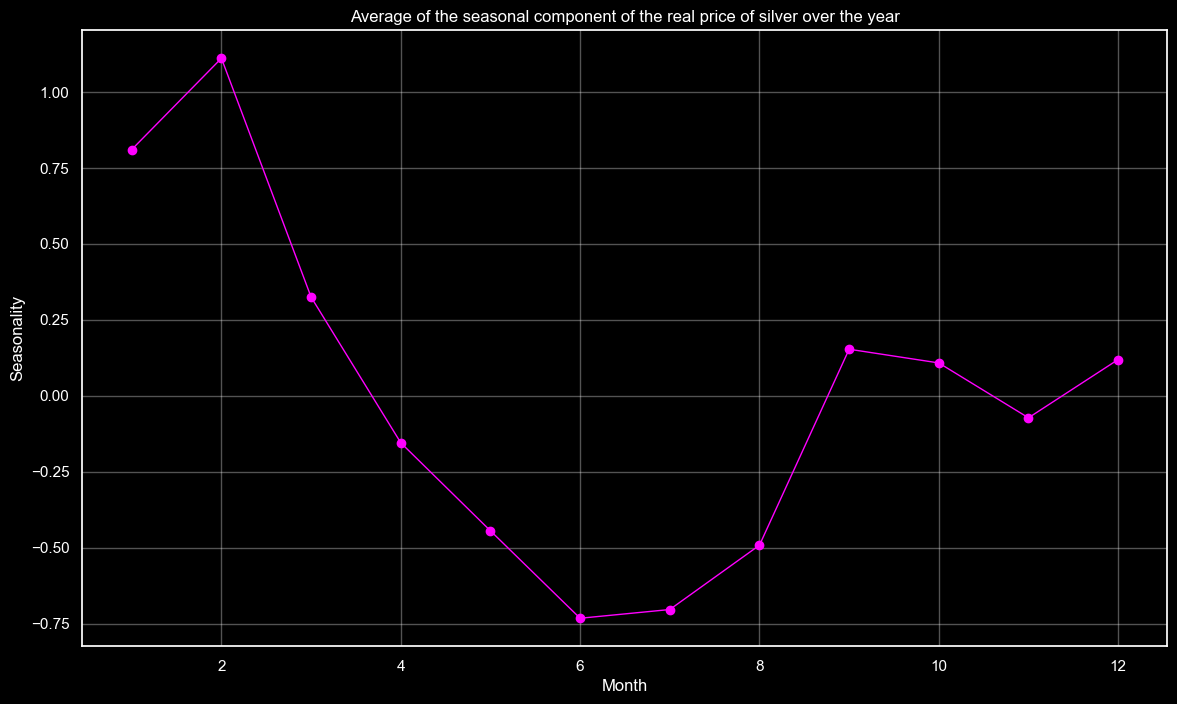

In [35]:
seasonal = stl.seasonal
monthly_avgs = seasonal.groupby(seasonal.index.month).mean()

plt.figure(figsize=(14, 8))

plt.plot(monthly_avgs.index, monthly_avgs.values, marker='o', color="fuchsia", linewidth=1)

plt.title("Average of the seasonal component of the real price of silver over the year")
plt.xlabel("Month")
plt.ylabel("Seasonality")

plt.show()

- seasonality is...

 No need to check anything related to volatility or short-term price analysis.